# Valencian Real Estate Market Price Analyis

## Table of Contents
- [0. Introduction](#intro)
- [1. Gather Data](#gather)
- [2. Assess Data](#assess)
- [3. Clean Data](#clean)
- [4. Data Exploration](#exploration)
- [5. Save Clean Data](#save)
- [6. Create Web App Graphics](#plotly)


<a id='intro'></a>
## 0. Introduction

This notebooks is used to analyze the real estate prices in Valencia. First data is queries via the Idealista API, after that the received data is analyzed.

Questions:

1. What are the average prices in the different districts/neighborhoods of Valencia?
2. What area in Valencia has the best raito rent/sale price?
3. What are the renting prices in the different districts/neighborhoods of Valencia?
4. Are sale prices for flats in the city centre of Valencia rising or falling over time?
5. How long are sale listings publicated before the flat is bought?

Wit that knowledge the following questions can be answered viewing listings:
- Is the price per area of a certain flat good?



### Configure

In [1]:
# API call
import base64
import requests
import json

# standard libs
import os
import re
from pathlib import Path
import json
from datetime import datetime
import getpass
import configparser

# data retrieval
import boto3
from botocore.exceptions import ClientError

# data analysis 
import pandas as pd
pd.set_option('display.max_columns', None)

# data plotting
import seaborn as sns
from matplotlib import pyplot as plt



ModuleNotFoundError: No module named 'requests'

In [6]:
# initialize config parser
config = configparser.ConfigParser()
config.read('valenciaHousingAnalysis.cfg')

['valenciaHousingAnalysis.cfg']

<a id='gather'></a>
## 1. Gather Data

In [7]:
# API 
#key = config.get("API","KEY");
#secret = config.get('API','SECRET');

### 1.1 Code for AWS Lambda Function

The AWS Lamba function downloads once per week all available listings in a defined area of Valencia.

The following filter are applied when requesting the idealista API:

* 'property_type' : 'homes',
* 'center' : '39.4693441,-0.379561',
* 'distance' : '1500',
* 'minSize' : '100',
* 'maxSize' : '160',
* 'elevator' : 'True',
* 'preservation' : 'good',
* 'order' : 'distance',
* 'sort' : 'asc',
       

![search radius](images/SearchRadius.png "Search Radius")


In [5]:
def get_oauth_token(key, secret):
    '''Function creates personalised idealista token from key secret pair.'''
    
    message = key + ":" + secret # Combine the API key and  secret to personalised message
    auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii") # Encode the message   
    headers = {"Authorization" : auth, "Content-Type" : "application/x-www-form-urlencoded;charset=UTF-8"} # Define headers   
    params = {"grant_type" : "client_credentials", "scope" : "read"} # Define request params
    request = requests.post("https://api.idealista.com/oauth/token", headers=headers, params=params)  # Perform the request with the api url, headers and params
    token = json.loads(request.text)['access_token'] # Obtain  personalised token, as a json  

    return token

In [6]:
# function to create search url
def define_request_url(operation):
    '''Function combines search parameters with the url to create search url for request.'''
    
    config = {
       'base_url': 'https://api.idealista.com/3.5/',
       'country': 'es',
       'max_items' : '50',
       'order' : 'distance',
       'center' : '39.4693441,-0.379561',
       'distance' : '1500',
       'property_type' : 'homes',
       'sort' : 'asc',
       'minSize' : '100',
       'maxSize' : '160',
       'elevator' : 'True',
       'airConditioning' : 'True',
       'preservation' : 'good',
       'language': 'en'
       }
    
    url = (config['base_url'] 
           + config['country'] 
           +'/search?operation=' + operation 
           +'&maxItems=' + config['max_items'] 
           + '&order=' + config['order'] 
           + '&center=' + config['center'] 
           + '&distance=' + config['distance'] 
           + '&propertyType=' + config['property_type'] 
           + '&sort=' + config['sort'] 
           + '&minSize=' +config['minSize']
           + '&maxSize=' + config['maxSize']
           + '&numPage=%s' 
           + '&elevator=' + config['elevator'] 
           #+'&airConditioning' + config['airConditioning']
           + '&preservation' + config['preservation'] 
           + '&language=' + config['language'])
    
    return url

In [7]:
# function to request data from idealista API
def query_api(key, secret, url):  
    '''Function uses requests package to query the idealista API with given token and search url.'''
    
    token = get_oauth_token(key, secret) # get the personalised token  
    headers = {'Content-Type': 'Content-Type: multipart/form-data;', # define the search headers  
               'Authorization' : 'Bearer ' + token}

    content = requests.post(url, headers = headers) # return the content from the request  

    if content.text == '': # Transform the result as a json file
        print('Error: Exceeded API call limit or wrong parameters')
        result = None
    else: result = content.text #json.loads(content.text)   

    return result

In [8]:
# request data and loop through all pages

now=datetime.now()
date_time=now.strftime('%Y%m%d_%H%M%S')
    
url = define_request_url('rent') # 'sale'

page = 1
total_pages = 1 # 5

while page <= 1: #total_pages:

    url_of_page = url %(page) # Add the pagination to the url
    
    page_result_json = query_api(key_pau, secret_pau, url_of_page) # Get the search results
    page_result = json.loads(page_result_json)
    total_pages = page_result['totalPages'] # Get amount of pages
    
    filename='listings_' + date_time + '_' + str(page) + '.json'
    
    """
    s3.put_object(
        Bucket=bucket, 
        Key=filename,
        Body=page_result_json
        )
    """
    
    page += 1


NameError: name 'key_pau' is not defined

In [9]:
total_pages

1

### 1.2 Download json files from S3 

After the AWS Lambda function requested data via the idealista API it saved it as JSON files in an S3 bucket. The next step is to download the data from the S3 bucket to be able to analyze it locally.

In [8]:
# Check internet connection
requests.get("https://aws.amazon.com/de/")

<Response [200]>

In [9]:
# AWS Secrets
aws_key_id = getpass.getpass('AWS Access Key ID')
aws_secret = getpass.getpass('AWS Secret')

In [10]:
# configure s3 client

region = 'eu-central-1'
bucket = 'valencialistings'

s3_client = boto3.client('s3',
                        region_name=region,
                        aws_access_key_id=aws_key_id,
                        aws_secret_access_key=aws_secret,
                        ) 

In [24]:
# create list with names of all locally available files
local_files = os.listdir('./data/s3/')

# download all json files that are not already locally available using pagination
paginator = s3_client.get_paginator('list_objects')
page_iterator = paginator.paginate(Bucket=bucket)

file_count = 0
downloaded_count = 0

for page in page_iterator:
    if 'Contents' not in page:
        continue
    
    for key in page['Contents']:
        file_count += 1
        
        # if file already downloaded, skip 
        if key['Key'] in local_files:
            #print(f"File {key['Key']} already in local folder")
            continue
        
        else:
            # download json file from S3
            s3_client.download_file(bucket, key['Key'], f"data/s3/{key['Key']}")
            downloaded_count += 1
            if downloaded_count % 100 == 0:
                print(f"Downloaded {downloaded_count} files so far...")

print(f"Total files in S3: {file_count}")
print(f"Downloaded: {downloaded_count}")
print(f"Already local: {file_count - downloaded_count}")


Downloaded 100 files so far...
Downloaded 200 files so far...
Downloaded 300 files so far...
Downloaded 400 files so far...
Downloaded 500 files so far...
Downloaded 600 files so far...
Downloaded 700 files so far...
Downloaded 800 files so far...
Downloaded 900 files so far...
Downloaded 1000 files so far...
Downloaded 1100 files so far...
Downloaded 1200 files so far...
Downloaded 1300 files so far...
Downloaded 1400 files so far...
Downloaded 1500 files so far...
Downloaded 1600 files so far...
Downloaded 1700 files so far...
Downloaded 1800 files so far...
Downloaded 1900 files so far...
Downloaded 2000 files so far...
Downloaded 2100 files so far...
Downloaded 2200 files so far...
Downloaded 2300 files so far...
Total files in S3: 2373
Downloaded: 2373
Already local: 0


### 1.3 Create dataframe from downloaded csvs

In [15]:
# read one json into dataframe

""" 
with open('./data/s3/listings_20230118_174107_1.json') as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data['elementList'])
df.head()
"""

" \nwith open('./data/s3/listings_20230118_174107_1.json') as json_data:\n    data = json.load(json_data)\n\ndf = pd.DataFrame(data['elementList'])\ndf.head()\n"

In [28]:
# read all json into dataframe
df_all_pages = pd.DataFrame()
pathlist = Path('./data/s3/').glob('**/*.json')

for path in pathlist:
     
     path_str = str(path) # because path is object not string
     #print(path_str)
     
     # Match both 'sale_' and 'rent_' files with any number of digits for page number
     m = re.search('data/s3/(sale|rent)_([0-9]{8})_([0-9]{6})_([0-9]+).json', path_str)
     if m:
          operation = m.group(1)  # 'sale' or 'rent'
          found_1 = m.group(2)    # date
          found_2 = m.group(3)    # time
          found_3 = m.group(4)    # page number
          #print(found_1 + ' ' + found_2+ ' ' + found_3)
          
          date_time_obj = datetime.strptime(found_1, '%Y%m%d')

          with open(path_str) as json_data:
               data = json.load(json_data)
               df_page = pd.DataFrame(data['elementList'])
               df_page['dateDownload']= date_time_obj
               df_all_pages = pd.concat([df_all_pages, df_page])
     else:
          print(f"Skipping file that doesn't match pattern: {path_str}")


In [29]:
# see dataframe with all data         
df_all_pages.head(n=3)

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,priceInfo,propertyType,operation,size,exterior,rooms,bathrooms,address,province,municipality,district,country,neighborhood,latitude,longitude,showAddress,url,distance,description,hasVideo,status,newDevelopment,hasLift,parkingSpace,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,highlight,dateDownload,change,savedAd,notes,labels,newDevelopmentFinished,superTopHighlight,newDevelopmentHighlight
0,105385770,https://img4.idealista.com/blur/WEB_LISTING/0/...,M-122,35,3,2000.0,{'price': {'amount': 2000.0}},flat,rent,156.0,True,5,2,"calle de Colón, 72",València,València,L'Eixample,es,El Pla del Remei,39.470582,-0.369883,True,https://www.idealista.com/inmueble/105385770/,842,Vivienda de 140 m2 aproximadamente con plaza d...,False,good,False,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",13.0,{'typology': 'flat'},"{'subtitle': 'El Pla del Remei, València', 'ti...",False,False,False,False,False,False,NaN,2024-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105224797,https://img4.idealista.com/blur/WEB_LISTING/0/...,VALR51215,47,2,2200.0,{'price': {'amount': 2200.0}},flat,rent,157.0,True,4,2,barrio Arrancapins,València,València,Extramurs,es,Arrancapins,39.469598,-0.389385,False,https://www.idealista.com/inmueble/105224797/,843,Lucas Fox presenta este luminoso piso reciente...,True,good,False,True,NaN,14.0,{'typology': 'flat'},"{'subtitle': 'Arrancapins, València', 'title':...",False,False,True,False,False,False,NaN,2024-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105093907,https://img4.idealista.com/blur/WEB_LISTING/0/...,1124,27,bj,1700.0,{'price': {'amount': 1700.0}},flat,rent,160.0,True,4,2,barrio Arrancapins,València,València,Extramurs,es,Arrancapins,39.461949,-0.381897,False,https://www.idealista.com/inmueble/105093907/,846,Piso Reformado para Estudiantes en Zona Exclus...,False,good,False,True,NaN,11.0,{'typology': 'flat'},"{'subtitle': 'Arrancapins, València', 'title':...",False,False,False,False,False,False,NaN,2024-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='assess'></a>
## 2. Assess Data

After gathering each of the above pieces of data, they are assessed visually and programmatically for quality and tidiness issues. Requirements to be met:

- Quality requirements:
    - Completeness: All necessary records in dataframes, no specific rows, columns or cells missing.
    - Validity: No records available, that do not conform schema.
    - Accuracy: No wrong data, that is valid.
    - Consistency: No data, that is valid and accurate, but referred to in multiple correct ways.
- Tidiniss requirements (as defined by Hadley Wickham):
    - each variable is a column
    - each observation is a row
    - each type of observational unit is a table.

### 2.1 Visual assessment

In [30]:
df_all_pages.sample(n=3)

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,priceInfo,propertyType,operation,size,exterior,rooms,bathrooms,address,province,municipality,district,country,neighborhood,latitude,longitude,showAddress,url,distance,description,hasVideo,status,newDevelopment,hasLift,parkingSpace,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,highlight,dateDownload,change,savedAd,notes,labels,newDevelopmentFinished,superTopHighlight,newDevelopmentHighlight
11,105335704,https://img4.idealista.com/blur/WEB_LISTING/0/...,ZJ400,31,1,400000.0,"{'price': {'amount': 400000.0, 'currencySuffix...",flat,sale,117.0,True,3,2,calle del Pla de la Saïdia,València,València,La Saïdia,es,Morvedre,39.481778,-0.378311,False,https://www.idealista.com/inmueble/105335704/,1386,TEMPOCASA te ofrece EN EXCLUSIVA esta GRAN OPO...,False,good,False,True,NaN,3419.0,{'typology': 'flat'},"{'subtitle': 'Morvedre, València', 'title': 'P...",False,False,False,False,False,False,NaN,2024-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,105820086,https://img4.idealista.com/blur/WEB_LISTING/0/...,13273,18,6,850000.0,"{'price': {'amount': 850000.0, 'currencySuffix...",penthouse,sale,105.0,True,2,2,calle de Borriana,València,València,L'Eixample,es,Gran Vía,39.466132,-0.369079,False,https://www.idealista.com/inmueble/105820086/,968,Grupo Alain Inmobiliaria vende. Exclusivo y lu...,False,good,False,True,NaN,8095.0,"{'typology': 'flat', 'subTypology': 'penthouse'}","{'subtitle': 'Gran Vía, València', 'title': 'Á...",True,False,False,False,False,False,NaN,2024-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,104472637,https://img3.idealista.com/blur/WEB_LISTING/0/...,7775,12,7,580000.0,{'price': {'amount': 580000.0}},flat,sale,145.0,True,3,2,calle de Conca,València,València,Extramurs,es,Arrancapins,39.464709,-0.388895,False,https://www.idealista.com/inmueble/104472637/,952,¡Descubre una oportunidad única con Agencia Me...,False,good,False,True,NaN,4000.0,{'typology': 'flat'},"{'subtitle': 'Arrancapins, València', 'title':...",True,False,False,False,False,False,{'groupDescription': 'Destacado'},2024-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2 Programmatic assessment

In [31]:
# Check datatypes and non-null count of columns in df_twitter_archive_enhanced
df_all_pages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111473 entries, 0 to 49
Data columns (total 48 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   propertyCode             111473 non-null  object        
 1   thumbnail                111132 non-null  object        
 2   externalReference        92033 non-null   object        
 3   numPhotos                111473 non-null  int64         
 4   floor                    109614 non-null  object        
 5   price                    111473 non-null  float64       
 6   priceInfo                67996 non-null   object        
 7   propertyType             111473 non-null  object        
 8   operation                111473 non-null  object        
 9   size                     111473 non-null  float64       
 10  exterior                 110048 non-null  object        
 11  rooms                    111473 non-null  int64         
 12  bathrooms                

In [32]:
# Statistical description for sales
df_all_pages[['operation', 'dateDownload', 'latitude', 'longitude', 'distance', 'propertyCode', 'price', 'priceByArea', 'size', 'floor', 'rooms', 'bathrooms']].query('operation == "sale"').describe()

,dateDownload,latitude,longitude,price,priceByArea,size,rooms,bathrooms
count,70928,70928.000000,70928.000000,7.092800e+04,70928.000000,70928.000000,70928.000000,70928.000000
mean,2024-06-08 16:10:18.407399,39.468129,-0.379942,4.558897e+05,3554.850369,128.321396,3.269597,1.933707
min,2023-04-09 00:00:00,39.455859,-0.397017,6.500000e+04,537.000000,100.000000,0.000000,0.000000
25%,2023-10-01 00:00:00,39.464296,-0.386255,3.340000e+05,2667.000000,113.000000,3.000000,2.000000
50%,2024-04-28 00:00:00,39.468001,-0.379966,4.250000e+05,3245.000000,129.000000,3.000000,2.000000
75%,2025-01-26 00:00:00,39.471842,-0.374116,5.300000e+05,4205.000000,142.000000,4.000000,2.000000
max,2025-12-28 00:00:00,39.482774,-0.362170,2.400000e+06,17647.000000,160.000000,21.000000,4.000000
std,NaN,0.005615,0.008201,1.952199e+05,1416.004869,17.624807,0.972870,0.444032


In [33]:
# Statistical description for rent
df_all_pages[['operation', 'dateDownload', 'latitude', 'longitude', 'distance', 'propertyCode', 'price', 'priceByArea', 'size', 'floor', 'rooms', 'bathrooms']].query('operation == "rent"').describe()

,dateDownload,latitude,longitude,price,priceByArea,size,rooms,bathrooms
count,40545,40545.000000,40545.000000,40545.000000,40545.000000,40545.000000,40545.000000,40545.000000
mean,2024-09-19 15:50:03.329633,39.469147,-0.377388,2046.270070,16.376372,125.964509,2.985744,1.953040
min,2023-04-09 00:00:00,39.456095,-0.396998,400.000000,3.000000,100.000000,0.000000,1.000000
25%,2024-02-04 00:00:00,39.464967,-0.382820,1510.000000,13.000000,110.000000,2.000000,2.000000
50%,2024-09-29 00:00:00,39.468989,-0.376801,1900.000000,15.000000,124.000000,3.000000,2.000000
75%,2025-05-25 00:00:00,39.473143,-0.372077,2500.000000,19.000000,140.000000,3.000000,2.000000
max,2025-12-28 00:00:00,39.482746,-0.362233,6000.000000,56.000000,160.000000,7.000000,5.000000
std,NaN,0.005549,0.007425,658.894538,5.076367,17.619228,0.833928,0.440148


-> Zero rooms and zero bathrooms does not seem plausible for an apartment of interest.

In [34]:
# look into listings where rooms = 0
df_all_pages[df_all_pages.rooms == 0.0].groupby(['propertyType'])['propertyCode'].count()


propertyType
studio    251
Name: propertyCode, dtype: int64

->Listings with zero rooms seem to be always of proprtyType studio, that is plausible

In [35]:
# look into listings where bathrooms = 0
df_all_pages[df_all_pages.bathrooms == 0.0].groupby(['neighborhood'])['propertyCode'].count()

neighborhood
El Carme            236
El Pla del Remei     24
La Seu                9
Nou Moles             2
Russafa              12
Name: propertyCode, dtype: int64

->All apartments without bathroom seem to be located in the neighborhood El Carme. These apartments can be ignored.

In [36]:
# amount of listings p

df_all_pages.district.unique()

array(["L'Eixample", 'Extramurs', 'Ciutat Vella', 'Patraix',
       "L'Olivereta", 'Jesús', 'El Pla del Real', 'La Saïdia',
       'Quatre Carreres', 'Campanar'], dtype=object)

The districts `L'Olivereta`, `Patraix`, `Jesús`, `La Saïdia`, `Quatre Carreres`, `Campanar`, `El Pla del Real` are not in the focus of this analysis and for them listings are only partially retrieved. Therefore all districts other than `Extramurs`, `Ciutat Vella`, `L'Eixample`,  are dropped.

-> Less than x listings per week are not representive

### 2.3 Findings, which contradict requirements:

1. There are columns whith irrelevant information.
2. Validity: There are listings with 0.0 bathrooms.
3. Accuracy: Only keep relevant districts.
4. Validity: A sale price per area in Valencia over 10k Euros is not realistic

<a id='clean'></a>
## 3. Clean Data

#### Issue 1: irrelevant columns:

In [37]:
# only keep relevant data
df_reduced = df_all_pages[['dateDownload', 'operation', 'province', 'municipality' , 'district', 'neighborhood', 'latitude', 'longitude', 'distance', 'address', 'propertyCode', 'propertyType', 'price', 'priceByArea', 'size', 'floor', 'exterior', 'rooms', 'bathrooms', 'status', 'newDevelopment', 'hasLift', 'parkingSpace']]
df_reduced.head(n=1)

,dateDownload,operation,province,municipality,district,neighborhood,latitude,longitude,distance,address,propertyCode,propertyType,price,priceByArea,size,floor,exterior,rooms,bathrooms,status,newDevelopment,hasLift,parkingSpace
0,2024-07-14,rent,València,València,L'Eixample,El Pla del Remei,39.470582,-0.369883,842,"calle de Colón, 72",105385770,flat,2000.0,13.0,156.0,3,True,5,2,good,False,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."


#### Issue 2: Zero Bathrooms

In [38]:
# only keep appartments with at least one bathroom
df_clean = df_reduced[df_reduced.bathrooms > 0.0]
df_clean[df_clean.bathrooms < 1.0].head()

,dateDownload,operation,province,municipality,district,neighborhood,latitude,longitude,distance,address,propertyCode,propertyType,price,priceByArea,size,floor,exterior,rooms,bathrooms,status,newDevelopment,hasLift,parkingSpace


#### Issue 3: Only relevant districts

In [39]:
df_clean.propertyCode.count()

np.int64(111190)

In [40]:
# only keep listings from city center
df = df_clean[df_clean['district'].isin(["Extramurs", "Ciutat Vella", "L'Eixample"])]
df.district.unique()

array(["L'Eixample", 'Extramurs', 'Ciutat Vella'], dtype=object)

#### Issue 4: Price per Area of more than 10k in sale and less than 1k in sale are not in focus

In [41]:
df.priceByArea.max()

np.float64(17647.0)

In [42]:
# sale listings over 10k Euro pero square meter are ignored   
df = df[
((df.operation =='sale') & (df.priceByArea < 10000.0) & (df.priceByArea > 1000.0))
| (df.operation =='rent')
]

In [43]:
df.priceByArea.max()

np.float64(9929.0)

<a id='exploration'></a>
## 4. Data Exploration

In [44]:
df.head(3)

,dateDownload,operation,province,municipality,district,neighborhood,latitude,longitude,distance,address,propertyCode,propertyType,price,priceByArea,size,floor,exterior,rooms,bathrooms,status,newDevelopment,hasLift,parkingSpace
0,2024-07-14,rent,València,València,L'Eixample,El Pla del Remei,39.470582,-0.369883,842,"calle de Colón, 72",105385770,flat,2000.0,13.0,156.0,3,True,5,2,good,False,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."
1,2024-07-14,rent,València,València,Extramurs,Arrancapins,39.469598,-0.389385,843,barrio Arrancapins,105224797,flat,2200.0,14.0,157.0,2,True,4,2,good,False,True,NaN
2,2024-07-14,rent,València,València,Extramurs,Arrancapins,39.461949,-0.381897,846,barrio Arrancapins,105093907,flat,1700.0,11.0,160.0,bj,True,4,2,good,False,True,NaN


#### 4.1 Is there a risk of passing the API request Limit?

How many listings are downloaded every week?
The idealista API allows 100 requests per month, with 50 listings per request. In total this results into a maximum of 5000 listings per month.

In [45]:
# create dataframe with count of sale/rent properties downloaded per date
df_download_date = \
    df \
        .groupby(by=['dateDownload', 'operation']) \
        .agg({'propertyCode': ['count']}, as_index=False) \
        .reset_index() 
         
df_download_date.columns = list(map(''.join, df_download_date.columns.values))

df_download_date.head(n=50)

,dateDownload,operation,propertyCodecount
0,2023-04-09,rent,232
1,2023-04-09,sale,694
2,2023-04-16,rent,233
3,2023-04-16,sale,692
4,2023-04-23,rent,237
5,2023-04-23,sale,654
6,2023-04-30,rent,226
7,2023-04-30,sale,632
8,2023-05-07,rent,229
9,2023-05-07,sale,625


In [46]:
df_download_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dateDownload       285 non-null    datetime64[us]
 1   operation          285 non-null    object        
 2   propertyCodecount  285 non-null    int64         
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 6.8+ KB


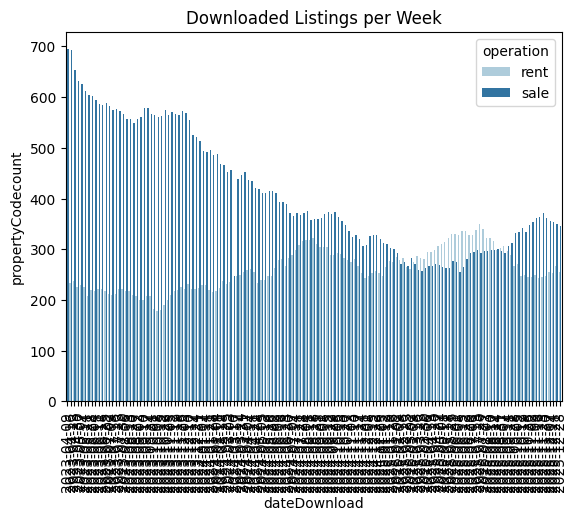

In [47]:
# plot the amount of downloaded listings per week
sns.barplot(df_download_date, x="dateDownload", y="propertyCodecount", hue="operation", palette = "Paired").set_title('Downloaded Listings per Week')
plt.xticks(rotation=90);

In [48]:
# mean count of downloaded sale and rent listings
df_download_mean = \
    df_download_date \
        .groupby(by=['operation']) \
        .agg({'propertyCodecount': ['mean']}, as_index=False) \
        .reset_index() 
         
df_download_mean.columns = list(map(''.join, df_download_mean.columns.values))

df_download_mean = df_download_mean.rename(columns={"propertyCodecountmean": "weeklyMean"})

df_download_mean['monthlyMean'] = df_download_mean['weeklyMean'] * 5

df_download_mean \
    .round(1) \
    .head(n=5)

,operation,weeklyMean,monthlyMean
0,rent,260.6,1302.9
1,sale,409.6,2048.1


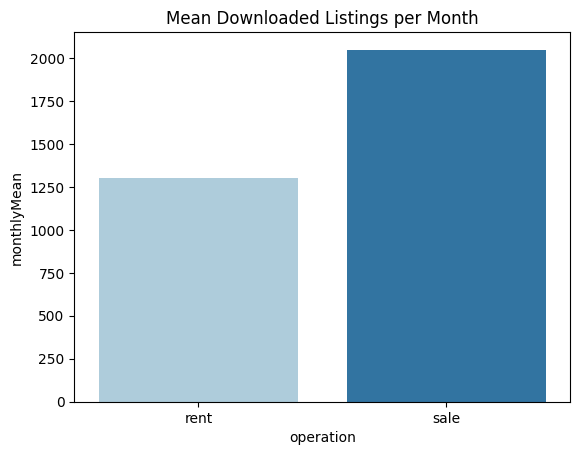

In [49]:
# plot max values for monthly downloaded listings
sns.barplot(df_download_mean, x="operation", y="monthlyMean", hue="operation", palette = "Paired").set_title('Mean Downloaded Listings per Month');

-> With a mean of 700 sale listings per week downloaded, even a month with 5 sundays will lead to only 3500 downloaded listings, which are 70 requests (less than the 100 request limit of the API)

#### 4.2 What are the mean prices per area by neighborhood for sales and rent?

In [50]:
# Statistics per neigbourhood including all non-duplicates
    #.drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last')
df_neighborhoods = \
    df \
        .groupby(by=['district', 'neighborhood', 'operation']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_neighborhoods.columns = ['district', 'neighborhood', 'operation', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']    

# join sales and rent information by for neighborhood
df_neighborhoods_rent_vs_sale = df_neighborhoods[(df_neighborhoods.operation == 'sale')].merge(
    df_neighborhoods[(df_neighborhoods.operation == 'rent')], 
    on=['neighborhood', 'district'], how='inner', suffixes=('_sale', '_rent')) \
    .drop(columns=['operation_sale', 'operation_rent']) \
    
df_neighborhoods_rent_vs_sale['mean_sales_price_by_rent_ratio'] = df_neighborhoods_rent_vs_sale.eval('mean_priceByArea_sale / mean_priceByArea_rent')

df_neighborhoods_rent_vs_sale = df_neighborhoods_rent_vs_sale[
    ['district', 'neighborhood', 
     'mean_priceByArea_sale', 'mean_priceByArea_rent', 'mean_sales_price_by_rent_ratio',
     'mean_size_sale', 'mean_size_rent',
     'count_listings_sale', 'count_listings_rent',
     'mean_prize_sale', 'mean_prize_rent']]

df_neighborhoods_rent_vs_sale \
    [(df_neighborhoods_rent_vs_sale['count_listings_sale'] >= 5) \
    & (df_neighborhoods_rent_vs_sale['count_listings_rent'] >= 5)] \
    .round(1) \
    .sort_values(['neighborhood'], ascending = [True]) \
    .head(n=60)

,district,neighborhood,mean_priceByArea_sale,mean_priceByArea_rent,mean_sales_price_by_rent_ratio,mean_size_sale,mean_size_rent,count_listings_sale,count_listings_rent,mean_prize_sale,mean_prize_rent
6,Extramurs,Arrancapins,3087.0,13.2,233.2,127.6,127.8,9890,5116,392097.8,1674.9
7,Extramurs,El Botànic,3278.7,17.4,188.2,130.8,126.1,2170,1528,430329.4,2170.0
0,Ciutat Vella,El Carme,3804.5,18.2,208.9,126.3,119.9,2820,2591,473662.8,2192.1
1,Ciutat Vella,El Mercat,3960.3,17.8,223.0,126.6,122.7,3110,1880,504750.2,2159.1
2,Ciutat Vella,El Pilar,3773.8,14.7,256.9,125.0,126.6,1664,1232,468430.0,1849.9
10,L'Eixample,El Pla del Remei,4624.4,18.7,247.5,132.1,132.7,4857,3692,606486.2,2450.2
11,L'Eixample,Gran Vía,4268.2,16.9,252.2,133.6,130.7,4396,3364,561571.2,2185.0
8,Extramurs,La Petxina,2950.7,13.6,216.7,124.5,123.1,4872,1543,363560.1,1670.8
9,Extramurs,La Roqueta,3564.8,14.5,246.6,128.2,125.5,5026,1196,455870.7,1793.9
3,Ciutat Vella,La Seu,3674.7,18.8,195.8,129.9,124.0,1307,1527,477833.2,2332.2


-> Arrancapins is the neighborhood with the most listings for sale

-> Sant Francesc ist the neighborhood with the most listings for rent

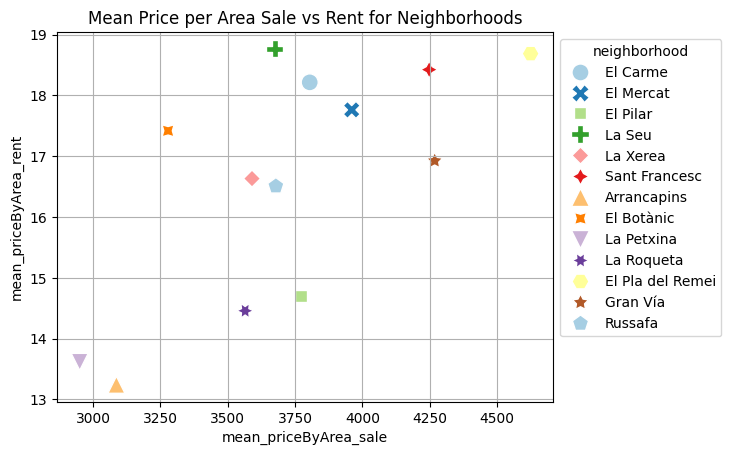

In [51]:
# scatterplot with mean price by are for sale vs rent
ax = sns.scatterplot(data=df_neighborhoods_rent_vs_sale, x="mean_priceByArea_sale", y="mean_priceByArea_rent", hue="neighborhood", style="neighborhood", s=150, palette = "Paired");
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Mean Price per Area Sale vs Rent for Neighborhoods');
plt.grid()

#### 4.3 For appartments, like ours, what are the prices per area by neighborhood for sales and rent?

In [52]:
# Statistics per district of non-duplicates with required specifics

df_neighborhoods_relevant_listings = \
    df[(df.hasLift == True)
    & (df.floor != '1')
    & (df.size > 120)
    & (df.rooms >= 2)
    & (df.bathrooms >= 2)] \
    .drop_duplicates(subset=['propertyCode'], keep='last') \
    #.drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \

df_neighborhoods_relevant_listings \
    .sort_values(['neighborhood'], ascending = [True]) \
    .head(n=3)

,dateDownload,operation,province,municipality,district,neighborhood,latitude,longitude,distance,address,propertyCode,propertyType,price,priceByArea,size,floor,exterior,rooms,bathrooms,status,newDevelopment,hasLift,parkingSpace
26,2024-07-14,rent,València,València,Extramurs,Arrancapins,39.465021,-0.388680,918,barrio Arrancapins,105421183,flat,1200.0,9.0,128.0,2,NaN,2,2,good,False,True,NaN
36,2023-06-11,rent,València,València,Extramurs,Arrancapins,39.465461,-0.384569,609,barrio Arrancapins,101438718,flat,1050.0,9.0,121.0,6,True,3,2,good,False,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."
49,2023-07-16,rent,València,València,Extramurs,Arrancapins,39.465109,-0.385858,716,Calle de Jesús,101845681,flat,1200.0,10.0,121.0,3,True,3,2,good,False,True,NaN


/var/folders/94/0r_yk_250mz3_pmr_x2fft2m0000gn/T/ipykernel_62779/2601538761.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_neighborhoods_relevant_listings.query('operation == "sale"'), x="priceByArea", y="neighborhood", order=grouped.index, palette = "Paired") \


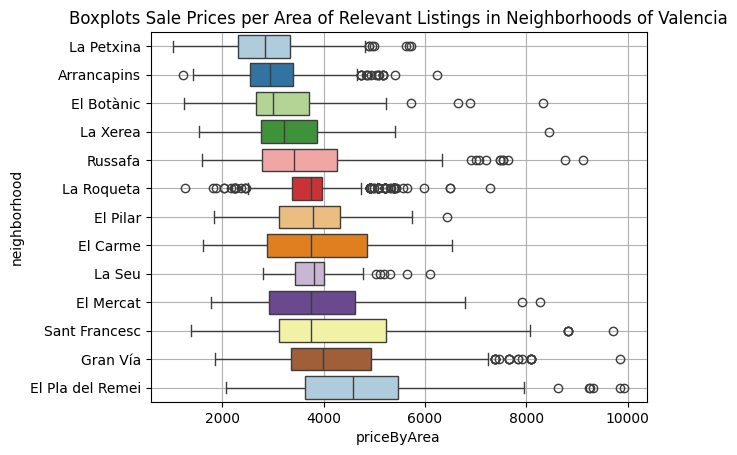

In [53]:
grouped = df_neighborhoods_relevant_listings.query('operation == "sale"').loc[:,['neighborhood', 'priceByArea']] \
    .groupby(['neighborhood']) \
    .mean() \
    .sort_values(by='priceByArea')
    
sns.boxplot(data=df_neighborhoods_relevant_listings.query('operation == "sale"'), x="priceByArea", y="neighborhood", order=grouped.index, palette = "Paired") \
    .set_title('Boxplots Sale Prices per Area of Relevant Listings in Neighborhoods of Valencia');
    
plt.grid()

/var/folders/94/0r_yk_250mz3_pmr_x2fft2m0000gn/T/ipykernel_62779/2506915321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_neighborhoods_relevant_listings.query('operation == "rent"'), x="priceByArea", y="neighborhood", order=grouped.index, palette = "Paired") \


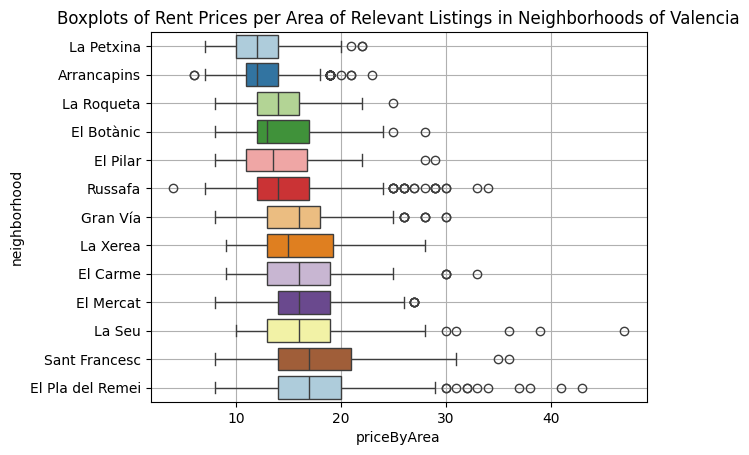

In [54]:
grouped = df_neighborhoods_relevant_listings.query('operation == "rent"').loc[:,['neighborhood', 'priceByArea']] \
    .groupby(['neighborhood']) \
    .mean() \
    .sort_values(by='priceByArea')
    
sns.boxplot(data=df_neighborhoods_relevant_listings.query('operation == "rent"'), x="priceByArea", y="neighborhood", order=grouped.index, palette = "Paired") \
    .set_title('Boxplots of Rent Prices per Area of Relevant Listings in Neighborhoods of Valencia');
    
plt.grid()

#### 4.4 How many listings are there for rent and sale in each neighborhood?

In [55]:
# Statistics of over time
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \
df_city_prices_time_series = \
    df \
        .groupby(by=['dateDownload', 'operation', 'district', 'neighborhood']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_city_prices_time_series.columns = ['dateDownload', 'operation', 'district', 'neighborhood', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']

df_city_prices_time_series \
    .round(1)
    
df_city_prices_time_series['dateDownload'] = df_city_prices_time_series['dateDownload'].astype('datetime64[ns]')

df_city_prices_time_series.head(n=3)

,dateDownload,operation,district,neighborhood,count_listings,mean_priceByArea,mean_size,mean_prize
0,2023-04-09,rent,Ciutat Vella,El Carme,8,14.875000,119.375000,1736.125
1,2023-04-09,rent,Ciutat Vella,El Mercat,17,13.764706,124.294118,1700.000
2,2023-04-09,rent,Ciutat Vella,El Pilar,20,16.350000,118.850000,1935.500


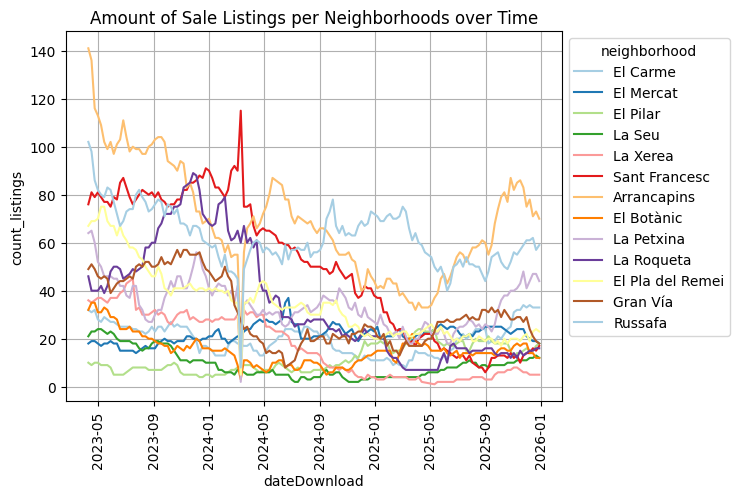

In [56]:
# line plot with amount of sale listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "sale"'), x="dateDownload", y="count_listings", hue="neighborhood", palette = "Paired")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Amount of Sale Listings per Neighborhoods over Time');
plt.grid()
plt.xticks(rotation=90);

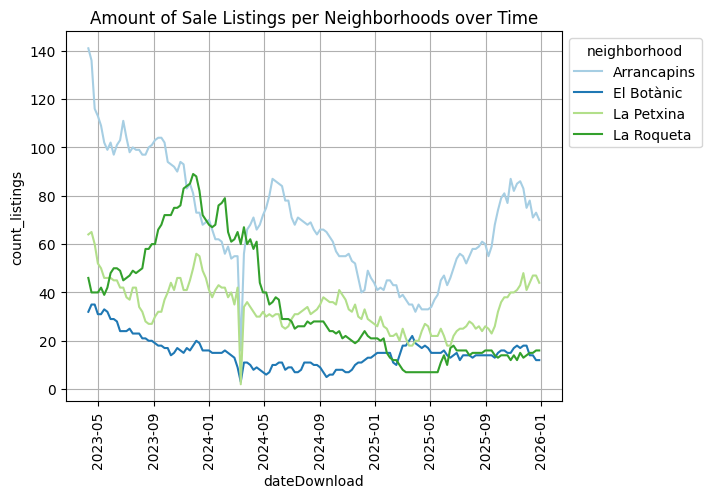

In [57]:
# line plot with amount of sale listings over time
ax = sns.lineplot(data=df_city_prices_time_series \
    .query('operation == "sale" & (district == "Extramurs")'),
            x="dateDownload", 
            y="count_listings", 
            hue="neighborhood", 
            palette = "Paired")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Amount of Sale Listings per Neighborhoods over Time');
plt.grid()
plt.xticks(rotation=90);

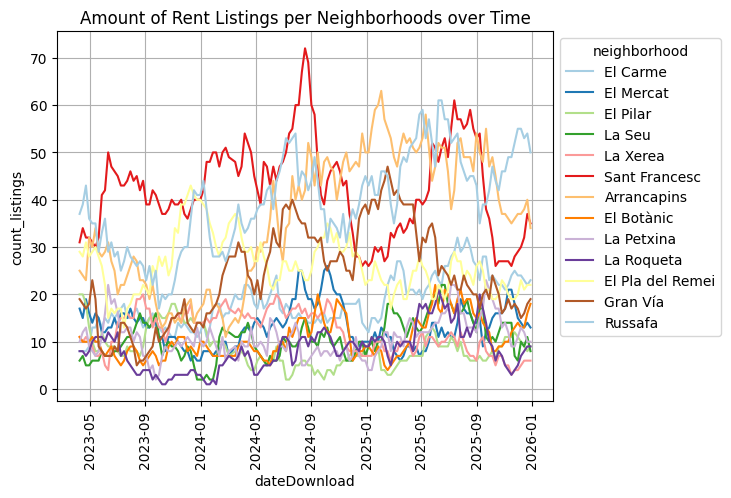

In [58]:
# line plot with amount of rent listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "rent"'), x="dateDownload", y="count_listings", hue="neighborhood", palette = "Paired")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Amount of Rent Listings per Neighborhoods over Time');
plt.grid()
plt.xticks(rotation=90);

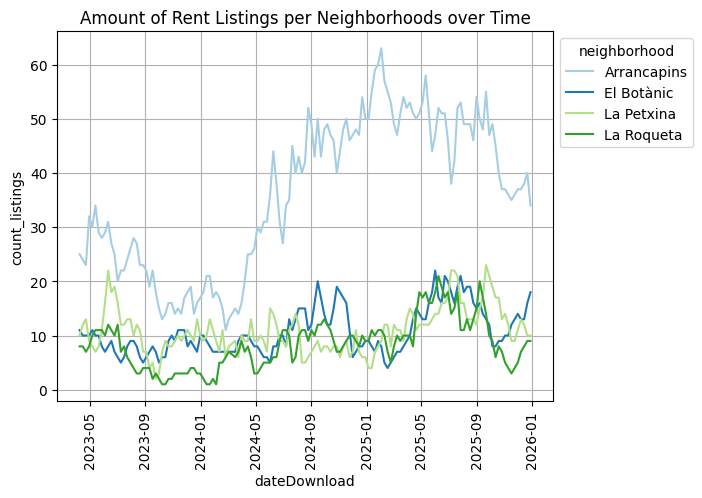

In [59]:
# line plot with amount of rent listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "rent" & district == "Extramurs"'), x="dateDownload", y="count_listings", hue="neighborhood", palette = "Paired")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Amount of Rent Listings per Neighborhoods over Time');
plt.grid()
plt.xticks(rotation=90);

In [60]:
# here sum of listings over all neighborhoods

#### 4.5 How do the prices of appartments in Valencia develop over time?

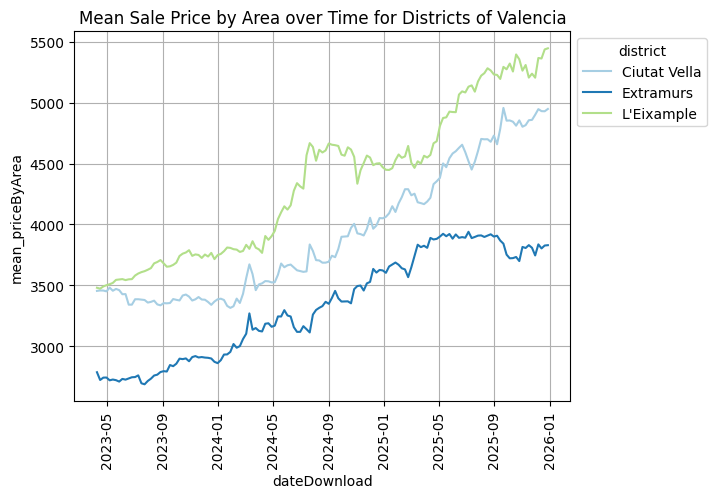

In [61]:
# line plot with amount of sale listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "sale"'), x="dateDownload", y="mean_priceByArea", hue="district", errorbar=None, palette = "Paired");
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Mean Sale Price by Area over Time for Districts of Valencia');
plt.grid();
plt.xticks(rotation=90);

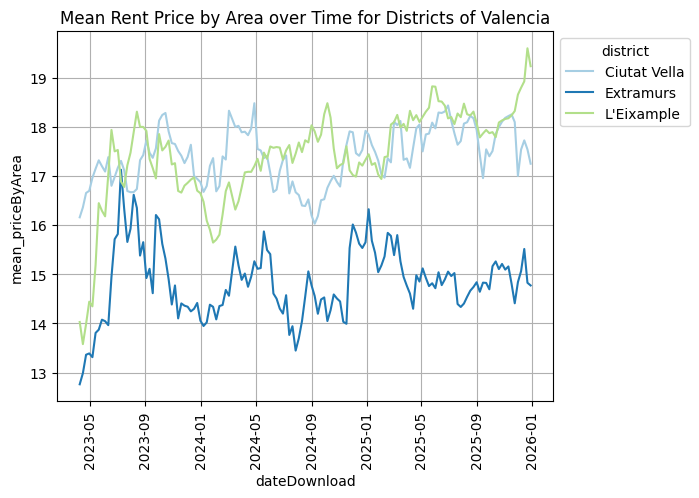

In [62]:
# line plot with amount of sale listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "rent"'), x="dateDownload", y="mean_priceByArea", hue="district", errorbar=None, palette = "Paired");
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Mean Rent Price by Area over Time for Districts of Valencia');
plt.grid();
plt.xticks(rotation=90);

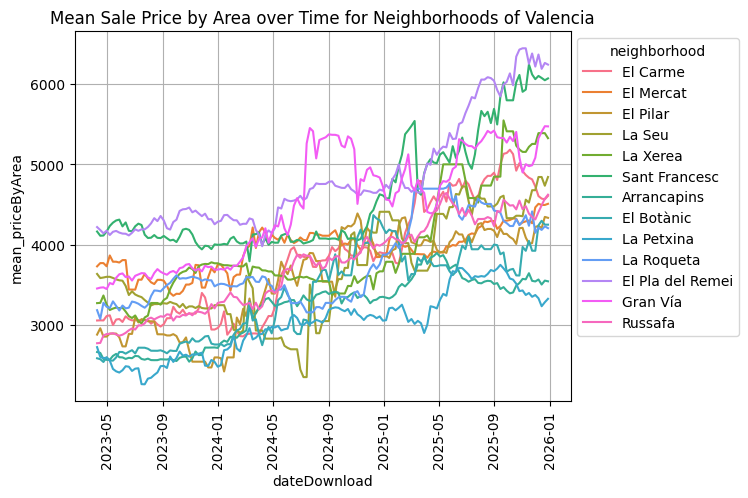

In [63]:
# line plot with amount of sale listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "sale"'), x="dateDownload", y="mean_priceByArea", hue="neighborhood")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Mean Sale Price by Area over Time for Neighborhoods of Valencia');
plt.grid()
plt.xticks(rotation=90);

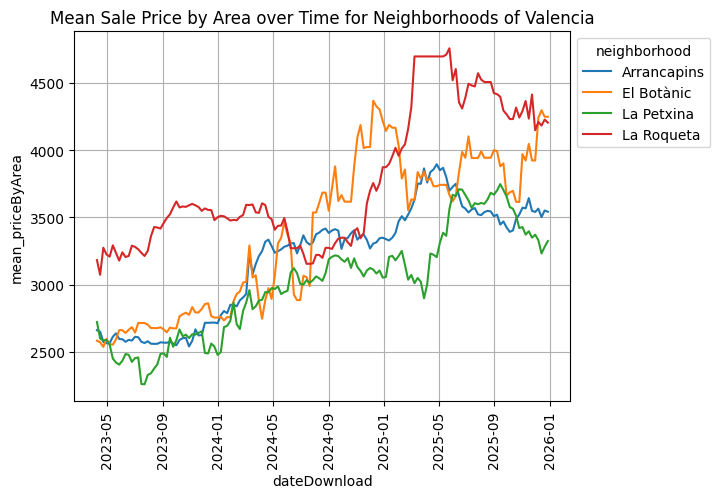

In [64]:
# line plot with amount of sale listings over time
ax = sns.lineplot(data=df_city_prices_time_series.query('operation == "sale" & district == "Extramurs"'), x="dateDownload", y="mean_priceByArea", hue="neighborhood")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
ax.set_title('Mean Sale Price by Area over Time for Neighborhoods of Valencia');
plt.grid()
plt.xticks(rotation=90);

#### Find Correlations

In [65]:
import numpy as np

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

ValueError: could not convert string to float: 'rent'

<a id='save'></a>
## 5. Save Data

In [64]:
# Write DataFrame to CSV without Index
df_all_pages.to_csv('./vlc_real_estate.csv', index=False)

<a id='plotly'></a>
## 6. Create Web App Graphics

In [65]:

def clean_data(path_to_data):
    """Clean world bank data for a visualizaiton dashboard

    """    
    df = pd.read_csv(path_to_data)

    # only keep relevant data
    df_reduced = df[['dateDownload', 'operation', 'province', 'municipality' , 'district', 'neighborhood', 'latitude', 'longitude', 'distance', 'address', 'propertyCode', 'propertyType', 'price', 'priceByArea', 'size', 'floor', 'exterior', 'rooms', 'bathrooms', 'status', 'newDevelopment', 'hasLift', 'parkingSpace']]

    # only keep appartments with at least one bathroom
    df_clean = df_reduced[df_reduced.bathrooms > 0.0]

    # only keep listings from city center
    df = df_clean[df_clean['district'].isin(["Extramurs", "Ciutat Vella", "L'Eixample"])]

    df['dateDownload'] = df['dateDownload'].astype('datetime64[ns]')
    #df.columns = df.columns.map('_'.join).str.strip('_')
        
    # sale listings over 10k Euro pero square meter are ignored   
    df = df[
        ((df.operation =='sale') & (df.priceByArea < 10000.0) & (df.priceByArea > 1000.0))
        | (df.operation =='rent')
        ]

    return df

def create_price_time_series(df):
    """Create dataframe with time series of sale and rent prics in Valencia"""
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \
    df_city_prices_time_series = \
        df \
            .groupby(by=['dateDownload', 'operation', 'district', 'neighborhood']) \
            .agg({'propertyCode': ['count'],
                'priceByArea': ['mean'], 
                'size': ['mean'], 
                'price': ['mean']
                }) \
            .reset_index() \

    df_city_prices_time_series.columns = ['dateDownload', 'operation', 'district', 'neighborhood', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']
    df_city_prices_time_series \
        .round(1)
                
    return df_city_prices_time_series


def calculate_mean_sale_and_rent_price_per_neighborhood(df):
    """Calculate sale price per area vs rent price per area per neigbourhood including all non-duplicates"""
    
    df_neighborhoods = df[(df.hasLift == True)
                    & (df.floor != '1')
                    & (df.size > 120)
                    & (df.rooms >= 2)
                    & (df.bathrooms >= 2)] \
                    .drop_duplicates(subset=['propertyCode'], keep='last') \
                    .groupby(by=['district', 'neighborhood', 'operation']) \
                    .agg({'propertyCode': ['count'],
                        'priceByArea': ['mean'], 
                        'size': ['mean'], 
                        'price': ['mean']
                        }) \
                    .reset_index() \

    df_neighborhoods.columns = ['district', 'neighborhood', 'operation', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']    

    # join sales and rent information by for neighborhood
    df_neighborhoods_rent_vs_sale = df_neighborhoods[(df_neighborhoods.operation == 'sale')].merge(
        df_neighborhoods[(df_neighborhoods.operation == 'rent')], 
        on=['neighborhood', 'district'], how='inner', suffixes=('_sale', '_rent')) \
        .drop(columns=['operation_sale', 'operation_rent']) \
        
    df_neighborhoods_rent_vs_sale['mean_sales_price_by_rent_ratio'] = df_neighborhoods_rent_vs_sale.eval('mean_priceByArea_sale / mean_priceByArea_rent')

    df_neighborhoods_rent_vs_sale = df_neighborhoods_rent_vs_sale[
        ['district', 'neighborhood', 
        'mean_priceByArea_sale', 'mean_priceByArea_rent', 'mean_sales_price_by_rent_ratio',
        'mean_size_sale', 'mean_size_rent',
        'count_listings_sale', 'count_listings_rent',
        'mean_prize_sale', 'mean_prize_rent']]

    df_neighborhoods_rent_vs_sale \
        [(df_neighborhoods_rent_vs_sale['count_listings_sale'] >= 5) \
        & (df_neighborhoods_rent_vs_sale['count_listings_rent'] >= 5)] \
        .round(1)
                    
    return df_neighborhoods_rent_vs_sale


In [66]:
import plotly.graph_objs as go

def return_figures():
    """Creates Plotly visualizations
    Args:
        None
    Returns:
        list (dict): list containing the four plotly visualizations
    """
    
    df = clean_data(path_to_data='./vlc_real_estate.csv')
    df_city_prices_time_series = create_price_time_series(df)
    
    # line chart of Mean Sale Prices per Area of Valencia Neighborhoods
    graph_one = []

    neighborhood_list = df_city_prices_time_series.neighborhood.unique().tolist()

    for neighborhood in neighborhood_list:
      x_val = df_city_prices_time_series[df_city_prices_time_series['neighborhood'] == neighborhood] \
        .query('operation == "sale"') \
        .dateDownload.tolist()
      y_val =  df_city_prices_time_series[df_city_prices_time_series['neighborhood'] == neighborhood] \
        .query('operation == "sale"') \
        .mean_priceByArea.tolist()
        
      graph_one.append(
          go.Scatter(
          x = x_val,
          y = y_val,
          mode = 'lines',
          name = neighborhood
          )
      )

    layout_one = dict(title = 'Mean Sale Price per Area of Valencia Neighborhoods.',
                xaxis = dict(title = 'Date'),
                yaxis = dict(title = 'Mean Price Per Area'),
                )
    
    """
    # second chart plots ararble land for 2015 as a bar chart    
      graph_two = []
      df = cleandata('data/API_AG.LND.ARBL.HA.PC_DS2_en_csv_v2.csv')
      df.columns = ['country','year','hectaresarablelandperperson']
      df.sort_values('hectaresarablelandperperson', ascending=False, inplace=True)
      df = df[df['year'] == 2015] 

      graph_two.append(
        go.Bar(
        x = df.country.tolist(),
        y = df.hectaresarablelandperperson.tolist(),
        )
      )

      layout_two = dict(title = 'Hectares Arable Land per Person in 2015',
                  xaxis = dict(title = 'Country',),
                  yaxis = dict(title = 'Hectares per person'),
                  )


  # third chart plots percent of population that is rural from 1990 to 2015
      graph_three = []
      df = cleandata('data/API_SP.RUR.TOTL.ZS_DS2_en_csv_v2_9948275.csv')
      df.columns = ['country', 'year', 'percentrural']
      df.sort_values('percentrural', ascending=False, inplace=True)
      for country in countrylist:
        x_val = df[df['country'] == country].year.tolist()
        y_val =  df[df['country'] == country].percentrural.tolist()
        graph_three.append(
            go.Scatter(
            x = x_val,
            y = y_val,
            mode = 'lines',
            name = country
            )
        )

      layout_three = dict(title = 'Change in Rural Population <br> (Percent of Total Population)',
                  xaxis = dict(title = 'Year',
                    autotick=False, tick0=1990, dtick=25),
                  yaxis = dict(title = 'Percent'),
                  )
      
  # fourth chart shows rural population vs arable land
      graph_four = []
      
      valuevariables = [str(x) for x in range(1995, 2016)]
      keepcolumns = [str(x) for x in range(1995, 2016)]
      keepcolumns.insert(0, 'Country Name')

      df_one = cleandata('data/API_SP.RUR.TOTL_DS2_en_csv_v2_9914824.csv', keepcolumns, valuevariables)
      df_two = cleandata('data/API_AG.LND.FRST.K2_DS2_en_csv_v2_9910393.csv', keepcolumns, valuevariables)
      
      df_one.columns = ['country', 'year', 'variable']
      df_two.columns = ['country', 'year', 'variable']
      
      df = df_one.merge(df_two, on=['country', 'year'])

      for country in countrylist:
        x_val = df[df['country'] == country].variable_x.tolist()
        y_val = df[df['country'] == country].variable_y.tolist()
        year = df[df['country'] == country].year.tolist()
        country_label = df[df['country'] == country].country.tolist()

        text = []
        for country, year in zip(country_label, year):
            text.append(str(country) + ' ' + str(year))

        graph_four.append(
            go.Scatter(
            x = x_val,
            y = y_val,
            mode = 'markers',
            text = text,
            name = country,
            textposition = 'top'
            )
        )

      layout_four = dict(title = 'Rural Population versus <br> Forested Area (Square Km) 1990-2015',
                  xaxis = dict(title = 'Rural Population'),
                  yaxis = dict(title = 'Forest Area (square km)'),
                  )
      
      graph_five = []
      df_five = cleandata('data/API_SP.RUR.TOTL_DS2_en_csv_v2_9914824.csv', ['Country Name', '2015'], ['2015'])

      df_five.columns = ['country','year','ruralpopulation']
      df_five.sort_values('ruralpopulation', ascending=False, inplace=True) 

      graph_five.append(
        go.Bar(
        x = df_five.country.tolist(),
        y = df_five.ruralpopulation.tolist(),
        )
      )

      layout_five = dict(title = 'Rural Population in 2015',
                  xaxis = dict(title = 'Country',),
                  yaxis = dict(title = 'Rural Population'))
    
    """
    
    # append all charts to the figures list
    figures = []
    figures.append(dict(data=graph_one, layout=layout_one))
    #figures.append(dict(data=graph_two, layout=layout_two))
    #figures.append(dict(data=graph_three, layout=layout_three))
    #figures.append(dict(data=graph_four, layout=layout_four))
    #figures.append(dict(data=graph_five, layout=layout_five))

    return figures

In [67]:
neighborhood_list = df['neighborhood'] \
      .sort_values(ascending = [True]) \
      .unique() \
      .tolist()
      
neighborhood_list

['Arrancapins',
 'El Botànic',
 'El Carme',
 'El Mercat',
 'El Pilar',
 'El Pla del Remei',
 'Gran Vía',
 'La Petxina',
 'La Roqueta',
 'La Seu',
 'La Xerea',
 'Russafa',
 'Sant Francesc']

In [68]:
neighborhood_list = df['neighborhood'] \
      .sort_values(ascending = [True]) \
      .unique() \
      .tolist()
      
neighborhood_list

['Arrancapins',
 'El Botànic',
 'El Carme',
 'El Mercat',
 'El Pilar',
 'El Pla del Remei',
 'Gran Vía',
 'La Petxina',
 'La Roqueta',
 'La Seu',
 'La Xerea',
 'Russafa',
 'Sant Francesc']

## TODO

* statistics:
  * how long is a property online
  * how are single property prices behaving over time

  * calculate years for ROI

In [162]:
Analysis which factors are related

SyntaxError: invalid syntax (118807554.py, line 1)